# Import Statements

In [1]:
import networkx as nx
import os
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from prettytable import PrettyTable

sns.set()
%matplotlib inline

In [26]:
import os, csv, re, json, string, ast, pickle
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable as PT
from pprint import pprint
from datetime import datetime
import matplotlib.colors as mcolors
from collections import Counter

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

# tweepy
import tweepy

# wordcloud
from wordcloud import WordCloud, STOPWORDS

# gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

In [271]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Reading the Data

In [2]:
dataset_path = os.path.join(os.getcwd(), r"..\datasets")
print(dataset_path)

C:\Project_Files\VT\SecondSem\SMA\Project\Notebooks\..\datasets


In [315]:
prod_path = os.path.join(dataset_path, "products_data.csv")
prod_graph_path = os.path.join(dataset_path, "products_copurchases_links.csv")

In [316]:
prod_df = pd.read_csv(prod_path, encoding = 'unicode_escape')
prod_df.head(5)

id        asin                                              title group  \
0   1  0827229534            Patterns of Preaching: A Sermon Sampler  Book   
1   2  0738700797                         Candlemas: Feast of Flames  Book   
2   3  0486287785   World War II Allied Fighter Planes Trading Cards  Book   
3   4  0842328327  Life Application Bible Commentary: 1 and 2 Tim...  Book   
4   5  1577943082    Prayers That Avail Much for Business: Executive  Book   

   salesrank  review_cnt  downloads  rating  
0     396585           2          2     5.0  
1     168596          12         12     4.5  
2    1270652           1          1     5.0  
3     631289           1          1     4.0  
4     455160           0          0     0.0

In [367]:
prod_df.shape

(542682, 8)

So there are around 540k products data.

In [5]:
network_df = pd.read_csv(prod_graph_path, encoding = 'unicode_escape')
network_df.head(5)

source  destination
0       1       161555
1       1       244916
2       1       118052
3       1       444232
4       1       500600

In [368]:
network_df.shape

(1231434, 2)

Amongst the products there are 1.2 Million Edges

In [6]:
prod_df = prod_df[prod_df["salesrank"] != -1]

Subsetting the dataset for the products whose sales rank is under 150000.

In [317]:
SALESRANK_TOP = 150000

books_df = prod_df[
    (prod_df["group"] == "Book") &
    (prod_df["salesrank"] <= SALESRANK_TOP)
]

In [318]:
books_df.shape

(74926, 8)

In [16]:
rating_dict = dict(books_df.rating.value_counts())

In [17]:
rating_dict.keys()

dict_keys([4.5, 5.0, 4.0, 0.0, 3.5, 3.0, 2.5, 2.0, 1.0, 1.5])

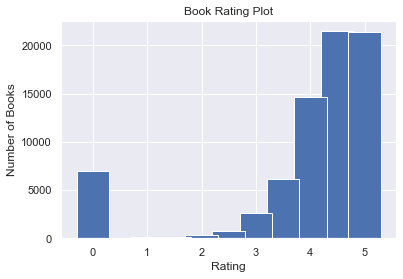

In [22]:
plt.title("Book Rating Plot")
plt.xlabel("Rating")
plt.ylabel("Number of Books")
plt.bar(rating_dict.keys(), rating_dict.values(), width=0.6);

Most of the Books have rating of 4.5 to 5 and almost zero with product rating 1.

In [23]:
# since products sales rank range from -1 upto 350k, taking those products that are under 150k
SALESRANK_TOP = 150000

music_df = prod_df[
    (prod_df["group"] == "Music") &
    (prod_df["salesrank"] <= SALESRANK_TOP)
]

In [24]:
music_ratings_dict = dict(music_df.rating.value_counts())

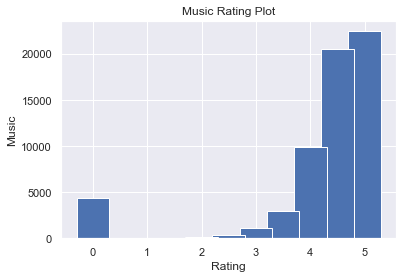

In [25]:
plt.title("Music Rating Plot")
plt.xlabel("Rating")
plt.ylabel("Music")
plt.bar(music_ratings_dict.keys(), music_ratings_dict.values(), width=0.6);

In [27]:
# enabling pyldavis to display visualizations
pyLDAvis.enable_notebook()

In [28]:
STOP_WORDS = stopwords.words('english')

In [30]:
def tweet_count(n):
    table = PT()
    table.field_names = ["Attribute", "Count"]
    table.add_row(["# Tweets", n])
    print(table)

In [31]:
def tokenzie(s):
    """
    Tokenizes the input string
    """
    return nltk.word_tokenize(s)

In [32]:
def remove_stopwords(words):
    """
    Removes stopwords from the tokens.
    """
    return [word for word in words if word not in STOP_WORDS]

In [33]:
def decontract_words(phrase):
    """
    Expands the contraction words.
    """
    # specific
    phrase = re.sub(r"haven\'t", "have not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"doesn\'t", "does not", phrase)
    phrase = re.sub(r"isn\'t", "is not", phrase)
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [165]:
def clean(text, remove_punc=False, remove_stop=False, perform_lemm=False, perform_bigrams=False):
    """
    1. Lowercase all words
    2. Remove Punctuations
    3. Remove stop words
    4. perform lemmatization
    5. generate bigrams
    """
    # expand text contractions
    text = decontract_words(str(text).lower())
    
    if remove_punc:
        # remove punctuations
        tokens = REGEX_TOKENIZER.tokenize(text)
    else:
        # just tokenize
        tokens = tokenzie(text)
        
    if remove_stop:
        # remove stopwords
        tokens = remove_stopwords(tokens)
        
    if perform_lemm:
        # perform lemmatization
        tokens = [LEMMATIZER.lemmatize(token) for token in tokens]
        
    if perform_bigrams:
        # generate bigrams
        tokens = list(ngrams(tokens, 2))
    return tokens

In [178]:
def plot_wordcloud(tweets_data, plot_title="", context_stopwords_list = []):
    """
    Plots the most frequent words as word cloud
    """
    tweet_text = " ".join((text.lower() for text in tweets_data.dropna()))
    stopwords = set(STOPWORDS)
    
    # updating the stopwords to include some context specific words
    if context_stopwords_list != []:
        stopwords.update(context_stopwords_list)
    stopwords.update(["RT", "t", "co", "https", "http", "amp", "U", "magazine", "subscription", "article"])
    
    # generate word cloud
    wordcloud = WordCloud(
        stopwords = stopwords,
        scale = 4,
        max_font_size = 50,
        max_words = 500,
        background_color = "black"
    ).generate(tweet_text)
    
    # plot the word cloud
    fig = plt.figure(1, figsize=(16, 16))
    plt.axis('off')
    fig.suptitle(plot_title, fontsize=20)
    fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

In [54]:
def plot_topic_wordcloud(lda_model, context_specific_sw=False, num_topics=4):
    """
    Plotting the most frequent words out of the Topic modelled topics.
    """
    print("Plotting Wordcloud")
    if num_topics %2 != 0:
        print("Cant plot odd number")
        return
    stop_words = stopwords.words('english')
    # if context_specific_sw == True:
    #     stop_words.extend(['vaccine', 'covid', 'covid19', 'astrazeneca', 'covaxin', 'pfizer', 'moderna'])
    
    # generate the word cloud
    cloud = WordCloud(stopwords=stop_words, background_color='black',
                     width=2500, height=1800, max_words=75,
                     colormap='tab10', color_func=lambda *args, **kwargs: COLORS[i])
    
    topics = lda_model.show_topics(formatted=False)
    
    # plot the wordcloud in a grid
    fig, axes = plt.subplots(num_topics//2,2, figsize=(10,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(f'Topic {i}', fontdict=dict(size=16))
        plt.gca().axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [37]:
def get_sentiment_scores(model, tweet):
    """
    Gets the sentiment scores for a sentence (compound, positive, neutral, negative)
    """
    scores = model.polarity_scores(tweet)
    return scores['compound'], scores['pos'], scores['neu'], scores['neg']

In [38]:
def label_sentiment(row):
    """
    Classifies a sentiment as Positive, Neutral or Negative.
    """
    cutoff = 0.5
    if row < -1 * cutoff:
        return "NEGATIVE"
    elif row > cutoff:
        return "POSITIVE"
    else:
        return "NEUTRAL"

In [39]:
def tweet_to_tokens(tweets):
    for tweet in tweets:
        yield (gensim.utils.simple_preprocess(tweet, deacc=True))
        
def remove_sw_gensim(tweets):
    return [[word.lower() for word in simple_process(tweet) 
             if word not in STOP_WORDS] for tweet in tweets]

In [40]:
# reference - https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [44]:
music_df.title.duplicated().value_counts()

False    51343
True     10520
Name: title, dtype: int64

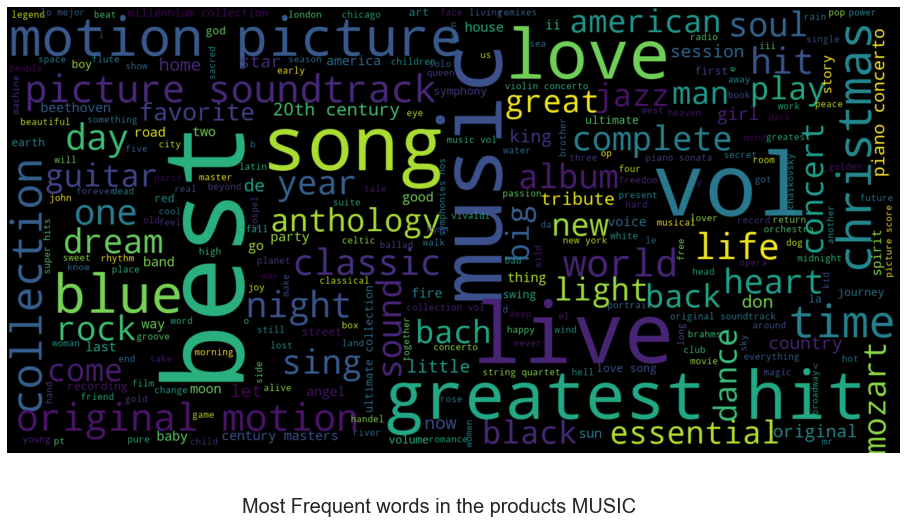

In [45]:
plot_wordcloud(music_df["title"], "Most Frequent words in the products MUSIC")

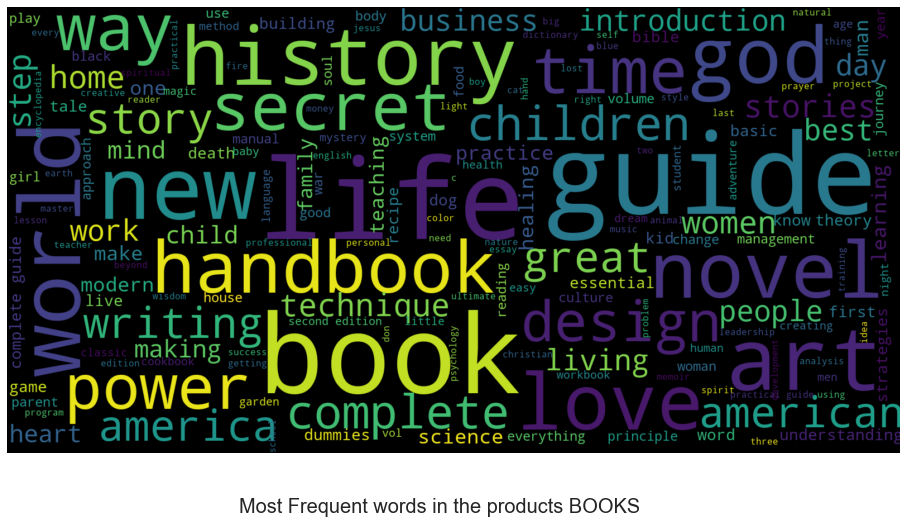

In [46]:
plot_wordcloud(books_df["title"], "Most Frequent words in the products BOOKS")

In [48]:
REGEX_TOKENIZER = nltk.tokenize.RegexpTokenizer(r'\w+')

In [49]:
music_df["tokens"] = music_df["title"].apply(clean, remove_punc=True, remove_stop=True)

C:\Users\surya\AppData\Local\Temp/ipykernel_35924/1517569428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df["tokens"] = music_df["title"].apply(clean, remove_punc=True, remove_stop=True)


In [50]:
dictionary_tokens = corpora.Dictionary(music_df["tokens"])

In [52]:
COLORS = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [432]:
dictionary_tokens.filter_extremes(no_below=3, no_above=0.3)
dictionary_tokens.compactify()

corpus_stem = [dictionary_tokens.doc2bow(prod) for prod in music_df["tokens"]]
LDAModel_stem = models.ldamodel.LdaModel(corpus_stem, num_topics=4, id2word=dictionary_tokens, passes=20)


Plotting Wordcloud


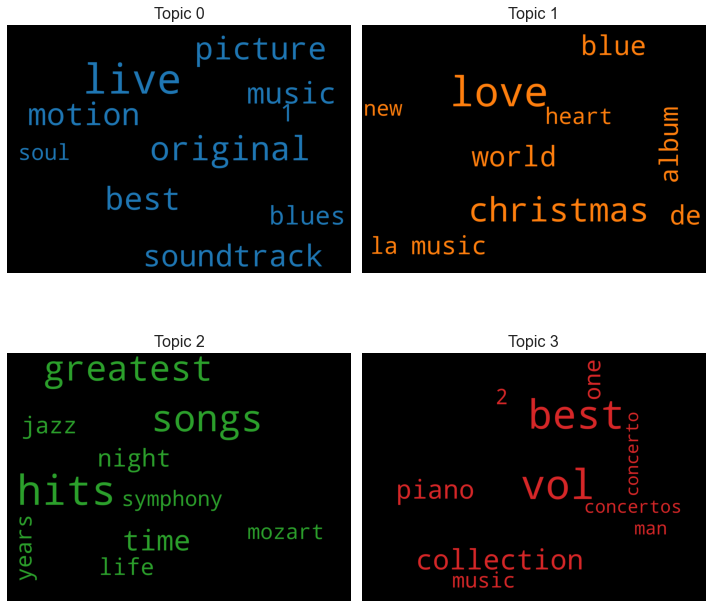

In [53]:
plot_topic_wordcloud(LDAModel_stem)

When looked at the Topics:

Topic - 0: About live and original musics.
Topic - 1: About Christmas and Festive musics.
Topic - 2: About various kinds of music like Mozart, Jazz, Symphony
Topic - 3: About instruments like Piano, Concerts

Plotting Wordcloud


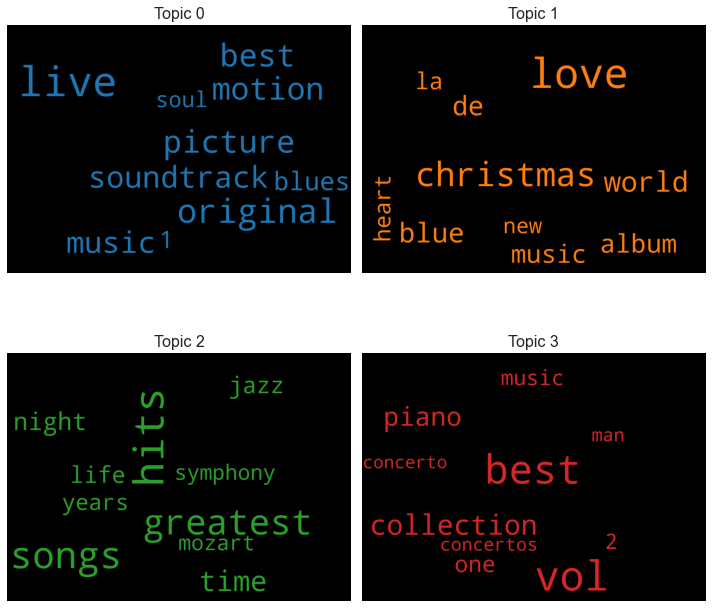

In [55]:
plot_topic_wordcloud(LDAModel_stem)

In [57]:
books_df["tokens"] = books_df["title"].apply(clean, remove_punc=True, remove_stop=True)
bk_dictionary_tokens = corpora.Dictionary(books_df["tokens"])

C:\Users\surya\AppData\Local\Temp/ipykernel_35924/3767029568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df["tokens"] = books_df["title"].apply(clean, remove_punc=True, remove_stop=True)


In [58]:
bk_dictionary_tokens.filter_extremes(no_below=3, no_above=0.3)
bk_dictionary_tokens.compactify()

corpus_stem = [bk_dictionary_tokens.doc2bow(prod) for prod in books_df["tokens"]]
LDAModel_stem = models.ldamodel.LdaModel(corpus_stem, num_topics=4, id2word=bk_dictionary_tokens, passes=20)


Plotting Wordcloud


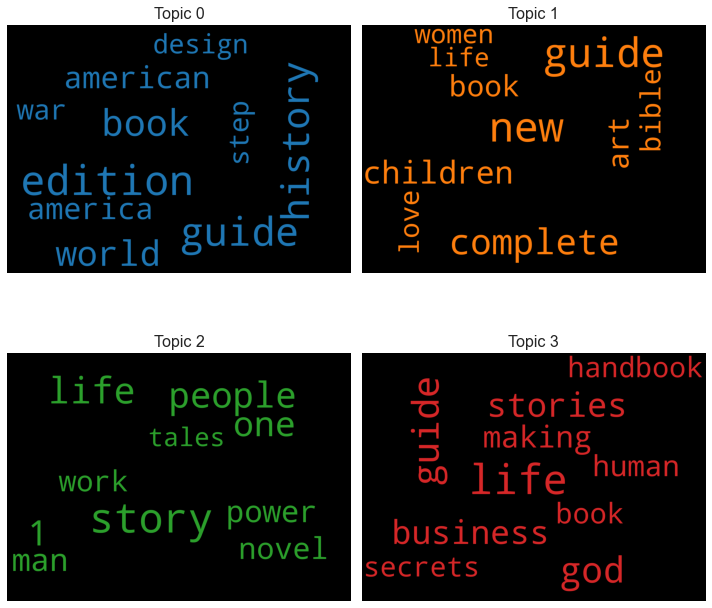

In [59]:
plot_topic_wordcloud(LDAModel_stem)

When looked at the Topics:

Topic - 0: About American history. <br/>
Topic - 1: About Women and Children. <br/>
Topic - 2: About Stories and Novels about work and life <br/>
Topic - 3: About business and strategies

In [60]:
vis = pyLDAvis.gensim_models.prepare(LDAModel_stem, corpus_stem, 
                                     dictionary=LDAModel_stem.id2word)
vis

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.207575  0.151923       1        1  26.760254
1     -0.173732  0.013553       2        1  26.200762
0      0.062904 -0.338860       3        1  24.582113
2      0.318402  0.173384       4        1  22.456871, topic_info=           Term         Freq        Total Category  logprob  loglift
53      edition  1250.000000  1250.000000  Default  30.0000  30.0000
181     history  1064.000000  1064.000000  Default  29.0000  29.0000
70          new  1642.000000  1642.000000  Default  28.0000  28.0000
250       story   783.000000   783.000000  Default  27.0000  27.0000
61        world  1178.000000  1178.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
885    building   237.987183   354.178809   Topic4  -5.5832   1.0960
551   christian   220.024333   298.781869   Topic4  -5.6617   1.1876
209        love   270.716249   793.891506   Topic4  -5.4544   0.4177
61        world   288.637913  1178.689172   Topic4  -5.3903   0.0866
1190     little   218.024433   474.161633   Topic4  -5.6708   0.7166

[195 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
453       4  0.999476         1
1822      4  0.993815       100
170       3  0.998234         2
531       4  0.994576      2000
1787      3  0.993921       2nd
...     ...       ...       ...
61        4  0.245188     world
1599      2  0.587191   writing
1599      3  0.413043   writing
711       3  0.994931  writings
483       1  0.997199      year

[192 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [62]:
music_df.head()

id                                              title  group  salesrank  \
6    7                                              Batik  Music       5392   
17  18                                        Sol to Soul  Music     109301   
21  22                                      Come What May  Music      83369   
33  34  Southern By the Grace of God: Lynyrd Skynyrd T...  Music      89264   
48  49                                   Murder She Wrote  Music      68749   

    review_cnt  downloads  rating  \
6            3          3     4.5   
17          15         15     5.0   
21           4          4     4.5   
33           6          6     4.0   
48           0          0     0.0   

                                               tokens  
6                                             [batik]  
17                                        [sol, soul]  
21                                        [come, may]  
33  [southern, grace, god, lynyrd, skynyrd, tribut...  
48                                    [murder, wrote]

In [63]:
music_copurchase_df = network_df[network_df.source.isin(music_df.id) &
                                 network_df.destination.isin(music_df.id)
                                ]
    

In [67]:
mus_in_degree = music_copurchase_df.groupby(['destination'])['source'].size().reset_index(name='in_degree')

In [68]:
# obtaining the out_degree of the graph
mus_out_degree = music_copurchase_df.groupby(['source'])['destination'].size().reset_index(name='out_degree')

In [69]:
mus_in_degree["in_degree"].min(), mus_in_degree["in_degree"].max()

(1, 82)

In [70]:
mus_out_degree["out_degree"].min(), mus_out_degree["out_degree"].max()

(1, 5)

In [71]:
# Top 5 product information
temp_1 = mus_out_degree.set_index('source')
temp_2 = mus_in_degree.set_index('destination').rename_axis('source')
temp_2.columns = temp_1.columns

merged = temp_2.add(temp_1, fill_value=0).loc[temp_2.index, :].reset_index()

In [74]:
merged.nlargest(10, 'out_degree')

source  out_degree
22774  291489        87.0
38369  484602        81.0
37771  477050        79.0
14691  186810        74.0
35787  452782        74.0
42207  528428        73.0
8074   102158        70.0
27069  346899        69.0
23604  301097        67.0
159      1593        65.0

In [402]:
top_1k = merged.nlargest(3000, 'out_degree')
bottom_1k = merged.nsmallest(1500, 'out_degree')

In [403]:
with open("top_and_bottom_1k_node_ids.txt", "w") as outfile:
    for node_ids in top_1k.iterrows():
        outfile.write(f"{int(node_ids[1].source)}\n")
    for node_ids in bottom_1k.iterrows():
        outfile.write(f"{int(node_ids[1].source)}\n")
        
    print("Done")

Done


## Top Connected Books

In [76]:
for row in merged.nlargest(10, 'out_degree').iterrows():
    # print(row[1].source)
    title = prod_df[prod_df['id'] == int(row[1].source)]
    print(f"Title: {title.iat[0,1]}")
    print(f"Outdegree: {row[1].out_degree}")
    print("#-----------------------------")

Title: Beethoven: Symphonien Nos
Outdegree: 87.0
#-----------------------------
Title: Kind of Blue
Outdegree: 81.0
#-----------------------------
Title: Saxophone Colossus
Outdegree: 79.0
#-----------------------------
Title: Dark Side of the Moon 30th Anniversary Edition
Outdegree: 74.0
#-----------------------------
Title: Tchaikovsky: Symphonies no 4  5
Outdegree: 74.0
#-----------------------------
Title: The Most Famous Opera Duets
Outdegree: 73.0
#-----------------------------
Title: Thelonious Monk with John Coltrane
Outdegree: 70.0
#-----------------------------
Title: Hoodoo Man Blues
Outdegree: 69.0
#-----------------------------
Title: The Very Best of the Spinners
Outdegree: 67.0
#-----------------------------
Title: Very Best of Frankie Valli and the Four Seasons
Outdegree: 65.0
#-----------------------------


In [77]:
for row in merged.nsmallest(10, 'out_degree').iterrows():
    # print(row[1].source)
    title = prod_df[prod_df['id'] == int(row[1].source)]
    print(f"Title: {title.iat[0,1]}")
    print(f"Outdegree: {row[1].out_degree}")
    print("#-----------------------------")

Title: Beyond Horizon
Outdegree: 1.0
#-----------------------------
Title: Do Re Mi
Outdegree: 1.0
#-----------------------------
Title: Living Out Loud
Outdegree: 1.0
#-----------------------------
Title: A Ma Zone
Outdegree: 1.0
#-----------------------------
Title: Flowing Stream: Chinese Folk Songs by Zhou Long
Outdegree: 1.0
#-----------------------------
Title: Adventures in Paradise
Outdegree: 1.0
#-----------------------------
Title: Karma Beats
Outdegree: 1.0
#-----------------------------
Title: And Then the Rain Falls
Outdegree: 1.0
#-----------------------------
Title: Passion
Outdegree: 1.0
#-----------------------------
Title: No Light in August
Outdegree: 1.0
#-----------------------------


# Sentiment Analysis on Reviews

Analyzing the reviews made on the products - (Books/Magazines)

In [149]:
reviews_path = r"C:\Project_Files\VT\SecondSem\SMA\Project\datasets\amazon-meta.txt\Magazine_Subscriptions\Magazine_Subscriptions.json"

In [151]:
reviews_df = pd.read_json(reviews_path, lines=True)

In [152]:
reviews_df.head()

overall vote  verified   reviewTime      reviewerID        asin  \
0        5    9     False   11 8, 2001   AH2IFH762VY5U  B00005N7P0   
1        5    9     False  10 31, 2001   AOSFI0JEYU4XM  B00005N7P0   
2        3   14     False  03 24, 2007  A3JPFWKS83R49V  B00005N7OJ   
3        5   13     False  11 10, 2006  A19FKU6JZQ2ECJ  B00005N7OJ   
4        5  NaN      True  07 14, 2014  A25MDGOMZ2GALN  B00005N7P0   

         reviewerName                                         reviewText  \
0        ted sedlmayr  for computer enthusiast, MaxPC is a welcome si...   
1     Amazon Customer  Thank god this is not a Ziff Davis publication...   
2         Bryan Carey  Antiques Magazine is a publication made for an...   
3  Patricia L. Porada  This beautiful magazine is in itself a work of...   
4               Alvey                          A great read every issue.   

                                           summary  unixReviewTime  \
0           AVID READER SINCE "boot"  WAS THE NAME      1005177600   
1                               The straight scoop      1004486400   
2  Antiques Magazine is Good, but not for Everyone      1174694400   
3                           THE  DISCERNING READER      1163116800   
4                                       Five Stars      1405296000   

                            style image  
0                             NaN   NaN  
1                             NaN   NaN  
2  {'Format:': ' Print Magazine'}   NaN  
3  {'Format:': ' Print Magazine'}   NaN  
4                             NaN   NaN

In [154]:
reviews_df.shape

(89689, 12)

In [155]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         89689 non-null  int64 
 1   vote            24103 non-null  object
 2   verified        89689 non-null  bool  
 3   reviewTime      89689 non-null  object
 4   reviewerID      89689 non-null  object
 5   asin            89689 non-null  object
 6   reviewerName    89687 non-null  object
 7   reviewText      89656 non-null  object
 8   summary         89670 non-null  object
 9   unixReviewTime  89689 non-null  int64 
 10  style           51398 non-null  object
 11  image           135 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 7.6+ MB


In [157]:
# dropping unwanted columns such as style, image, unixReviewTime, verified
unwanted_cols = ['reviewTime', 'unixReviewTime', 'style', 'image']

In [158]:
reviews_df.drop(unwanted_cols, inplace=True, axis=1)

In [159]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       89689 non-null  int64 
 1   vote          24103 non-null  object
 2   verified      89689 non-null  bool  
 3   reviewerID    89689 non-null  object
 4   asin          89689 non-null  object
 5   reviewerName  89687 non-null  object
 6   reviewText    89656 non-null  object
 7   summary       89670 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 4.9+ MB


In [160]:
reviews_df.overall.value_counts()

5    53790
4    12676
1    11029
3     6971
2     5223
Name: overall, dtype: int64

In [161]:
# intializing VADER for performing SentimentAnalyzer
VADER = SentimentIntensityAnalyzer()

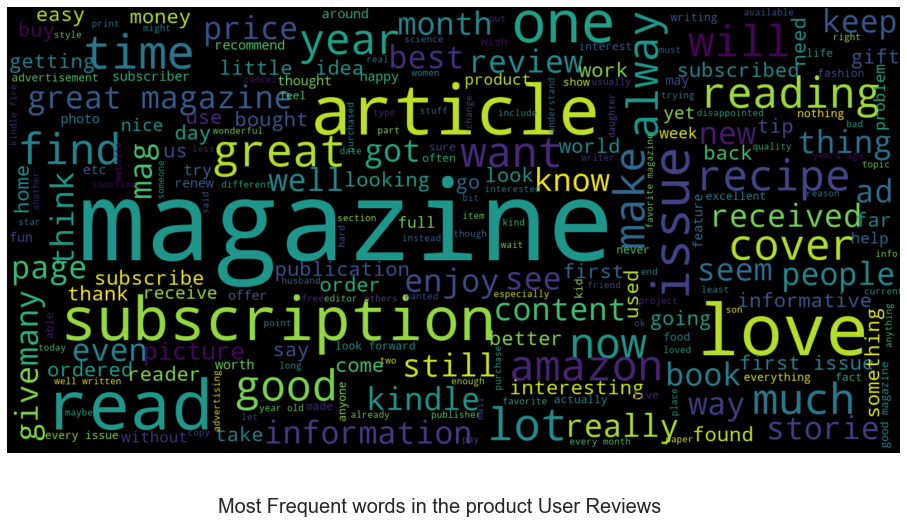

In [162]:
plot_wordcloud(reviews_df["reviewText"], "Most Frequent words in the product User Reviews")

In [166]:
LEMMATIZER = WordNetLemmatizer()
reviews_df["tokens"] = reviews_df["reviewText"].apply(clean, remove_stop=True, perform_lemm=True)

In [167]:
compound, pos, neu, neg = [], [], [], []
for review in reviews_df.iterrows():
    tweet_tokens = review[1]["tokens"]
    tweet_text = " ".join(tweet_tokens)
    com, p, nu, ng = get_sentiment_scores(VADER, tweet_text)
    compound.append(com)
    pos.append(p)
    neu.append(nu)
    neg.append(ng)

In [168]:
reviews_df["V_compound"] = compound
reviews_df["V_pos"] = pos
reviews_df["V_neu"] = neu
reviews_df["V_neg"] = neg

In [169]:
reviews_df["V_Sentiment"] = reviews_df["V_compound"].apply(label_sentiment) 

Printing Random Reviews and their sentiments to see the model performance.

In [174]:
sample = reviews_df[["reviewText", "V_Sentiment"]].sample(10)
for tweet in sample.iterrows():
    print("Review:", tweet[1].reviewText)
    print("Sentiment: ", tweet[1].V_Sentiment)
    print("#*************#")

Review: I love this magazine. Allrecipes website and Taste of Home cookbooks have always been my go-to for recipes. I love the quality of these magazines. We cook our way through every single magazine over the months. I only wish there were more vegetable/side recipes and that it came out more times a year. Everything we make, we make gluten-free so we are used to modifying recipes, but these recipes rarely need major changes. Soooo good!
Sentiment:  POSITIVE
#*************#
Review: I use this magazine to give me a business-specific supplement to my reading of The Economist.  That said they are two very different magazines. I like to think that The Economist calls issues down the middle and is conservative in their format, while Bloomberg seems to be a bit liberal and the format of the magazine makes you think they're out for some editorial award.  After subscribing for two years, I don't think I will renew.  I think that one can find almost all of the information offered in the issues

In [175]:
sample = reviews_df[reviews_df["V_Sentiment"] == "NEGATIVE"].sample(10)
for tweet in sample.iterrows():
    print("Review:", tweet[1].reviewText)
    print("Sentiment: ", tweet[1].V_Sentiment)
    print("#*************#")

Review: I have missed Norman Vincent Peal since he died. I thought it was over for the Guidepost. I was wrong. It is just as good today as yesterday Thank You
Sentiment:  NEGATIVE
#*************#
Review: Lots of ads and nothing really substantial to read. Also, I have subscribed to the paper version of this magazine and was terribly disappointed with the customer service. I have paid for one year and have never recieved my magazine-no matter how many times I called. Terrible, terrible, terrible customer service!!
Sentiment:  NEGATIVE
#*************#
Review: I'm a little disappointed with the magazine. While it covers interesting topics, the articles rarely go into enough detail. I also feel the overall slant of the magazine is somewhat negative, and there are rarely solutions or positive suggestions made in regards to the problems presented. I will not renew my subscription to this magazine.
Sentiment:  NEGATIVE
#*************#
Review: I have written to Amazon about this problem and re

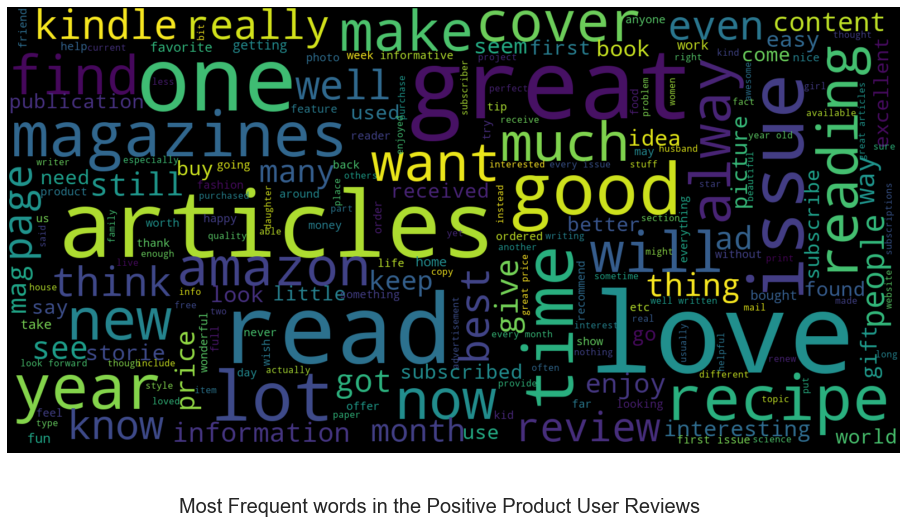

In [179]:
plot_wordcloud(reviews_df[reviews_df["V_Sentiment"] == "POSITIVE"]["reviewText"], "Most Frequent words in the Positive Product User Reviews")

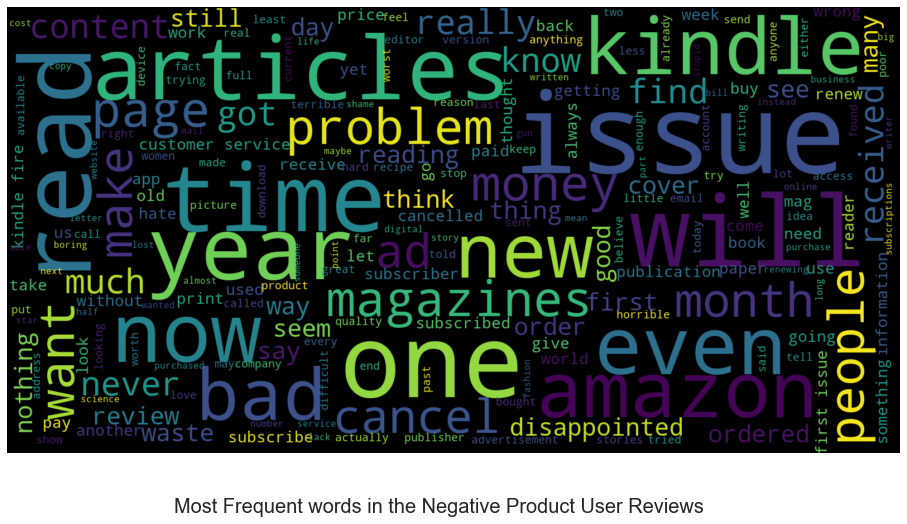

In [183]:
plot_wordcloud(reviews_df[reviews_df["V_Sentiment"] == "NEGATIVE"]["reviewText"], "Most Frequent words in the Negative Product User Reviews")

# Topic Modeling on Reviews

In [187]:
context_based_stop_words_list = ["magazine", "magazines", "article", "articles", "well", "one", "get", "amazon", "kindle", "book", "books"]
STOP_WORDS.extend(context_based_stop_words_list)

In [235]:
corpora_tokens = []
for idx, review in reviews_df.iterrows():
    corpora_tokens.append([token for token in review["tokens"] if len(token) > 2 and token not in STOP_WORDS])

In [236]:
    
id2word = corpora.Dictionary(corpora_tokens)
print(id2word)

id2word.filter_extremes(no_below=3, no_above=0.3)
print(id2word)

corpus = [id2word.doc2bow(d) for d in corpora_tokens]

Dictionary(55168 unique tokens: ['...', 'advanced', 'anyone', 'apps', 'audio']...)
Dictionary(17757 unique tokens: ['...', 'advanced', 'anyone', 'apps', 'audio']...)


In [190]:
lda_model = models.ldamulticore.LdaMulticore(corpus=corpus,
                            num_topics=4, id2word=id2word, workers=12, passes=20)

lda_model.print_topics()

[(0,
  '0.010*"like" + 0.010*"issue" + 0.008*"review" + 0.007*"read" + 0.006*"new" + 0.006*"year" + 0.006*"would" + 0.006*"many" + 0.005*"find" + 0.005*"time"'),
 (1,
  '0.046*"great" + 0.041*"love" + 0.021*"good" + 0.018*"recipe" + 0.016*"read" + 0.013*"like" + 0.012*"always" + 0.011*"year" + 0.011*"idea" + 0.011*"lot"'),
 (2,
  '0.008*"like" + 0.007*"read" + 0.006*"issue" + 0.006*"would" + 0.005*"good" + 0.005*"people" + 0.004*"girl" + 0.004*"..." + 0.004*"car" + 0.004*"year"'),
 (3,
  '0.033*"subscription" + 0.025*"issue" + 0.015*"year" + 0.012*"would" + 0.011*"first" + 0.010*"time" + 0.010*"received" + 0.009*"month" + 0.008*"like" + 0.008*"price"')]

In [192]:
def get_per_tweet_topic(df, ldaModel, corpus, columnName):
    topic_info = []
    for i in range(len(corpus)):
        topics = ldaModel.get_document_topics(corpus[i])
        topics = sorted(topics, key=lambda x: -x[1])
        topic_info.append(topics[0][0]) # get the top topic number
    df[columnName] = topic_info

In [193]:
get_per_tweet_topic(reviews_df, lda_model, corpus, "4_topics")

In [194]:
def plot_sentiment_vs_topics(df, topicNums, columnName, title):
    fig, axs = plt.subplots(len(topicNums), figsize=(10,10))
    fig.tight_layout()
    fig.suptitle(title)
    for top in range(len(topicNums)):
        topic_sent = dict(df[df[columnName] == top]["V_Sentiment"].value_counts())
        # axs[top].set_title(f"topic-{top}")
        axs[top].set_xlabel(f"Sentiment for topic {top}")
        axs[top].set_ylabel("Tweet Counts")
        axs[top].bar(topic_sent.keys(), topic_sent.values())
        
        for rect in axs[top].patches:
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            space = 1
            label = "{:.0f}".format(y_value)
            axs[top].annotate(label, (x_value, y_value), 
                             xytext = (0, space), textcoords = "offset points",
                             ha = "center", va="bottom")

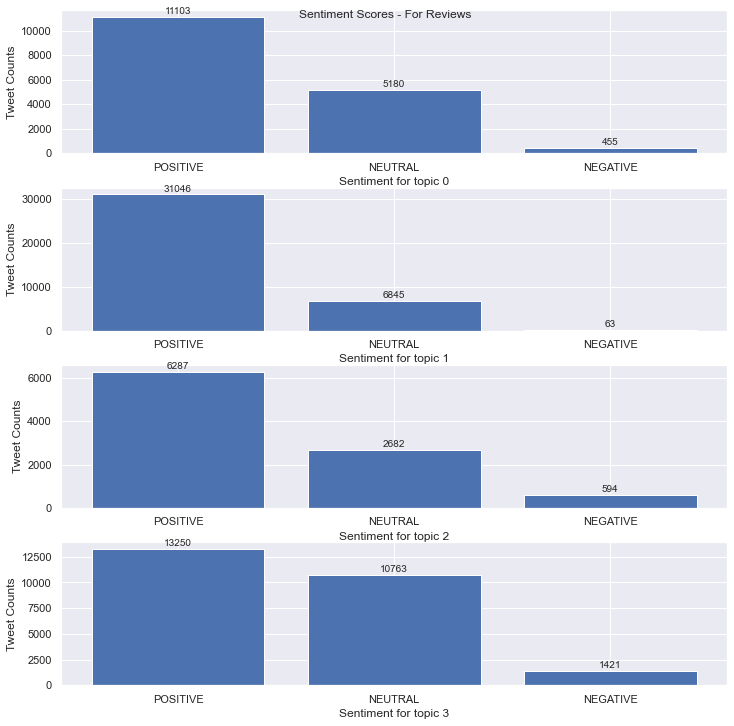

In [195]:
plot_sentiment_vs_topics(reviews_df, [0,1,2, 3], "4_topics", "Sentiment Scores - For Reviews")

Overall the sentiment of the books/magazines is Positve with few under Neutral categories.

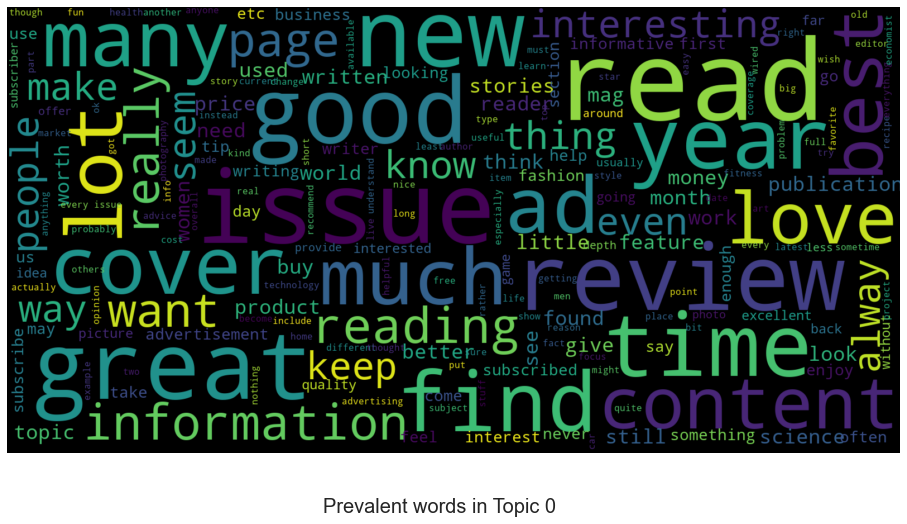

In [197]:
topic_0_wc = reviews_df[reviews_df["4_topics"] == 0]["reviewText"]
plot_wordcloud(topic_0_wc, "Prevalent words in Topic 0", STOP_WORDS)

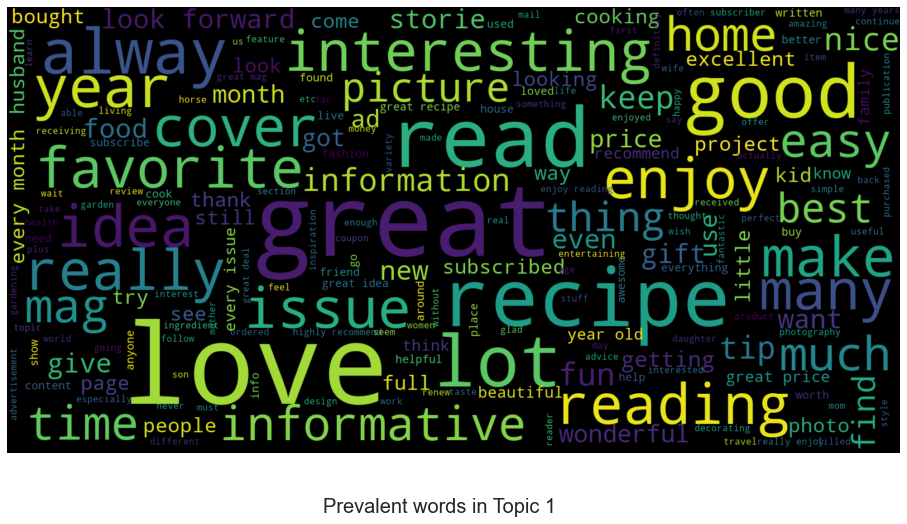

In [198]:
topic_1_wc = reviews_df[reviews_df["4_topics"] == 1]["reviewText"]
plot_wordcloud(topic_1_wc, "Prevalent words in Topic 1", STOP_WORDS)

In [199]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, 
                                     dictionary=lda_model.id2word)
vis

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.037890  0.060380       1        1  28.563941
3      0.197308 -0.020680       2        1  27.894493
1     -0.091401 -0.156856       3        1  24.209075
2     -0.068017  0.117156       4        1  19.332491, topic_info=              Term          Freq         Total Category  logprob  loglift
161           love  19881.000000  19881.000000  Default  30.0000  30.0000
232          great  22708.000000  22708.000000  Default  29.0000  29.0000
60    subscription  17676.000000  17676.000000  Default  28.0000  28.0000
3357        recipe   7680.000000   7680.000000  Default  27.0000  27.0000
518       received   4795.000000   4795.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
111          cover   1085.113612   5706.600477   Topic4  -5.7327  -0.0166
196        reading   1121.169375   8612.106647   Topic4  -5.7000  -0.3954
54          really   1096.010160   7630.130714   Topic4  -5.7227  -0.2970
237         review   1058.850613   6283.995074   Topic4  -5.7572  -0.1374
164           make   1031.065971   5397.324665   Topic4  -5.7838  -0.0119

[353 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.137029            ...
0         2  0.364785            ...
0         3  0.264360            ...
0         4  0.233857            ...
3112      4  0.997548  a-link-normal
...     ...       ...            ...
9871      4  0.997630           yoga
3835      3  0.993694          yummy
3835      4  0.010801          yummy
4628      2  0.991387           zoom
4628      3  0.005477           zoom

[775 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [200]:
lda_model_6 = models.ldamulticore.LdaMulticore(corpus=corpus,
                            num_topics=6, id2word=id2word, workers=12, passes=20)

lda_model_6.print_topics()

[(0,
  '0.031*"recipe" + 0.013*"home" + 0.013*"food" + 0.011*"like" + 0.010*"idea" + 0.010*"love" + 0.009*"issue" + 0.007*"living" + 0.007*"many" + 0.007*"cooking"'),
 (1,
  '0.014*"like" + 0.012*"woman" + 0.009*"fashion" + 0.007*"people" + 0.007*"would" + 0.006*"best" + 0.006*"thing" + 0.006*"want" + 0.005*"..." + 0.005*"car"'),
 (2,
  '0.032*"subscription" + 0.028*"issue" + 0.014*"would" + 0.012*"year" + 0.011*"first" + 0.011*"received" + 0.010*"time" + 0.010*"month" + 0.007*"like" + 0.007*"version"'),
 (3,
  '0.011*"read" + 0.009*"issue" + 0.007*"review" + 0.007*"like" + 0.007*"new" + 0.006*"time" + 0.006*"story" + 0.006*"news" + 0.005*"reading" + 0.005*"world"'),
 (4,
  '0.082*"love" + 0.029*"year" + 0.023*"read" + 0.020*"gift" + 0.018*"great" + 0.016*"reading" + 0.014*"subscription" + 0.013*"old" + 0.012*"every" + 0.010*"kid"'),
 (5,
  '0.072*"great" + 0.044*"good" + 0.020*"lot" + 0.018*"information" + 0.016*"read" + 0.016*"like" + 0.014*"interesting" + 0.014*"always" + 0.012*"pri

In [201]:
vis_6 = pyLDAvis.gensim_models.prepare(lda_model_6, corpus, 
                                     dictionary=lda_model_6.id2word)
vis_6

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.185858  0.074102       1        1  24.152930
3      0.039014  0.120674       2        1  24.039410
1      0.033368  0.089231       3        1  15.083832
5      0.130626 -0.107278       4        1  13.147781
0      0.093061  0.003063       5        1  12.125918
4     -0.110212 -0.179792       6        1  11.450129, topic_info=              Term          Freq         Total Category  logprob  loglift
161           love  20267.000000  20267.000000  Default  30.0000  30.0000
232          great  22785.000000  22785.000000  Default  29.0000  29.0000
79            good  15069.000000  15069.000000  Default  28.0000  28.0000
3357        recipe   7890.000000   7890.000000  Default  27.0000  27.0000
60    subscription  17652.000000  17652.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
38           issue   1986.911307  21505.821798   Topic6  -4.6040  -0.2146
468           much   1422.746468   7175.826822   Topic6  -4.9380   0.5490
91            time   1517.505450  10731.416869   Topic6  -4.8735   0.2111
711          story   1131.423540   5409.159786   Topic6  -5.1671   0.6026
0              ...   1121.177143   6461.661029   Topic6  -5.1762   0.4157

[512 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
0          1  0.317101       ...
0          2  0.105855       ...
0          3  0.222079       ...
0          4  0.072427       ...
0          5  0.109105       ...
...      ...       ...       ...
332        3  0.368094     young
332        4  0.000920     young
332        5  0.009202     young
332        6  0.606435     young
15428      6  0.983755  zoobooks

[1399 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 6, 1, 5])

In [202]:
lda_model_50 = models.ldamulticore.LdaMulticore(corpus=corpus,
                            num_topics=50, id2word=id2word, workers=12, passes=20)

lda_model_50.print_topics()

[(7,
  '0.096*"story" + 0.039*"quality" + 0.023*"short" + 0.018*"high" + 0.014*"fiction" + 0.013*"like" + 0.010*"issue" + 0.010*"game" + 0.007*"also" + 0.007*"little"'),
 (41,
  '0.056*"science" + 0.026*"popular" + 0.019*"technology" + 0.017*"scientific" + 0.011*"american" + 0.011*"keep" + 0.011*"latest" + 0.010*"computer" + 0.009*"mechanic" + 0.008*"student"'),
 (15,
  '0.138*"gift" + 0.047*"subscription" + 0.040*"husband" + 0.037*"friend" + 0.035*"christmas" + 0.035*"bought" + 0.020*"purchased" + 0.019*"gave" + 0.018*"enjoys" + 0.016*"birthday"'),
 (29,
  '0.017*"music" + 0.014*"review" + 0.011*"also" + 0.009*"section" + 0.009*"rock" + 0.008*"..." + 0.008*"like" + 0.008*"band" + 0.007*"question" + 0.006*"cover"'),
 (30,
  '0.116*"year" + 0.066*"old" + 0.038*"kid" + 0.033*"love" + 0.031*"daughter" + 0.023*"son" + 0.021*"loved" + 0.020*"reading" + 0.019*"subscription" + 0.017*"child"'),
 (9,
  '0.084*"edition" + 0.058*"expected" + 0.028*"item" + 0.026*"arrived" + 0.019*"subscription" +

In [226]:
# reference - https://radimrehurek.com/gensim/models/coherencemodel.html
from gensim.models.coherencemodel import CoherenceModel

In [227]:
from gensim.test.utils import common_corpus, common_dictionary

In [231]:
lda_50cm = CoherenceModel(model=lda_model_50, corpus=common_corpus, coherence='u_mass')

In [232]:
lda_50cm_coherence = lda_50cm.get_coherence()
print(lda_50cm_coherence)

-0.2310171865693464


In [233]:
lda_6cm = CoherenceModel(model=lda_model_6, corpus=common_corpus, coherence='u_mass')
lda_6cm_coherence = lda_6cm.get_coherence()
print(lda_6cm_coherence)

-0.5729592920866725


In [234]:
# lda_model

lda_4cm = CoherenceModel(model=lda_model, corpus=common_corpus, coherence='u_mass')
lda_4cm_coherence = lda_4cm.get_coherence()
print(lda_4cm_coherence)

-0.5156633628780053


It is observed that increasing the topics from 4 to 50 increased the Coherence Score. With further increasing we can get better scores. But due to the computational limitations couldn't explore for higher topic numbers.

In [203]:
vis_50 = pyLDAvis.gensim_models.prepare(lda_model_50, corpus, 
                                     dictionary=lda_model_50.id2word)
vis_50

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
28     0.260119  0.001658       1        1  7.139542
17     0.114088 -0.028678       2        1  4.045417
27    -0.146129 -0.128906       3        1  3.265980
45    -0.053775 -0.023822       4        1  3.173366
14     0.193280 -0.122032       5        1  2.856291
36     0.096598  0.151298       6        1  2.793671
19    -0.017706  0.038430       7        1  2.679414
30     0.094016 -0.185792       8        1  2.624664
32     0.103054  0.004618       9        1  2.621649
44    -0.099691  0.006317      10        1  2.607417
16     0.015198 -0.164502      11        1  2.538513
3      0.202124  0.028399      12        1  2.496664
38    -0.163538  0.014498      13        1  2.428010
35    -0.172790 -0.229891      14        1  2.374886
43     0.124519  0.083385      15        1  2.339519
0      0.080642  0.057716      16        1  2.244632
13    -0.105466  0.169970      17        1  2.240843
46     0.123380 -0.074766      18        1  2.152288
29    -0.021769  0.120403      19        1  2.123700
7     -0.016754  0.067286      20        1  2.052910
41    -0.127099  0.055150      21        1  2.044876
2     -0.106838 -0.187880      22        1  2.022472
42     0.051360  0.078341      23        1  1.933835
20    -0.116484  0.075331      24        1  1.899328
15     0.130383 -0.180736      25        1  1.862172
33     0.147776  0.022078      26        1  1.853839
39    -0.073334  0.063007      27        1  1.847120
26    -0.072389  0.060703      28        1  1.816157
47    -0.006619  0.093256      29        1  1.792410
25    -0.055730 -0.042476      30        1  1.761773
18    -0.032584 -0.220098      31        1  1.712441
49    -0.063068  0.057489      32        1  1.643353
10    -0.092912  0.121677      33        1  1.586919
22    -0.110034 -0.244656      34        1  1.509500
6      0.125786  0.041405      35        1  1.486439
12     0.023387  0.075584      36        1  1.474002
48    -0.028079 -0.025696      37        1  1.460742
31    -0.102900  0.067528      38        1  1.356580
11    -0.009817 -0.040614      39        1  1.248669
24    -0.058832  0.051937      40        1  1.217840
21    -0.048502  0.039270      41        1  1.203085
5      0.044667  0.076990      42        1  1.156776
4     -0.010458  0.040918      43        1  1.109129
40    -0.066435 -0.003404      44        1  1.067065
9      0.165348 -0.022480      45        1  1.014055
23    -0.013429 -0.040847      46        1  0.873695
8      0.020499  0.018941      47        1  0.872869
1     -0.063374  0.088682      48        1  0.862425
37    -0.064647  0.088153      49        1  0.827016
34     0.004958  0.006858      50        1  0.684042, topic_info=        Term          Freq         Total Category  logprob  loglift
161     love  18471.000000  18471.000000  Default  30.0000  30.0000
232    great  21216.000000  21216.000000  Default  29.0000  29.0000
79      good  14569.000000  14569.000000  Default  28.0000  28.0000
3357  recipe   7993.000000   7993.000000  Default  27.0000  27.0000
236      new   8295.000000   8295.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
54    really     90.742224   7737.565773  Topic50  -4.8726   0.5391
164     make     80.610066   5466.290836  Topic50  -4.9910   0.7682
239    stuff     62.584326   1726.914662  Topic50  -5.2441   1.6673
69     worth     61.947351   3273.826514  Topic50  -5.2543   1.0175
70      year     59.255655  16414.314695  Topic50  -5.2987  -0.6391

[3622 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
7440      43  0.946340    'cause
10085      8  0.064108       'em
10085     35  0.929566       'em
11557     42  0.969198      'new
10525     23  0.926463     'nuff
...      ...       ...       ...
6062       2  0.986576     zinio
12046      8  0.937995       zoo
15428     21  0.9

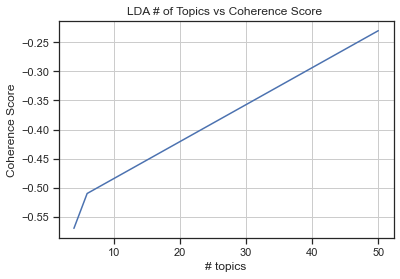

In [431]:

plt.title("LDA # of Topics vs Coherence Score ")
plt.xlabel("# topics")
plt.ylabel("Coherence Score")
plt.plot([4,6,50], [-0.57, -0.51, -0.23])
plt.grid()
plt.show()

In [369]:
pyLDAvis.save_html(vis_50, 'lda_50_topics_book_reviews.html')

## Performing similar analysis on Appliances

In [204]:
# appliances_path = r"C:\Project_Files\VT\SecondSem\SMA\Project\datasets\amazon-meta.txt\Magazine_Subscriptions\Appliances.json"
appliances_path = os.path.join(os.getcwd(), r"..\datasets\Appliances.json")

In [205]:
appliances_df = pd.read_json(appliances_path, lines=True)

In [209]:
appliances_df.shape

(602777, 13)

In [206]:
appliances_df.head()

overall vote  verified   reviewTime      reviewerID        asin  \
0        5    2     False  11 27, 2013  A3NHUQ33CFH3VM  1118461304   
1        5  NaN     False   11 1, 2013  A3SK6VNBQDNBJE  1118461304   
2        5  NaN     False  10 10, 2013  A3SOFHUR27FO3K  1118461304   
3        5  NaN     False   10 9, 2013  A1HOG1PYCAE157  1118461304   
4        5   10     False   09 7, 2013  A26JGAM6GZMM4V  1118461304   

                            style              reviewerName  \
0       {'Format:': ' Hardcover'}                    Greeny   
1  {'Format:': ' Kindle Edition'}           Leif C. Ulstrup   
2       {'Format:': ' Hardcover'}  Harry Gilbert Miller III   
3       {'Format:': ' Hardcover'}            Rebecca Ripley   
4       {'Format:': ' Hardcover'}             Robert Morris   

                                          reviewText  \
0  Not one thing in this book seemed an obvious o...   
1  I have enjoyed Dr. Alan Gregerman's weekly blo...   
2  Alan Gregerman believes that innovation comes ...   
3  Alan Gregerman is a smart, funny, entertaining...   
4  As I began to read this book, I was again remi...   

                                             summary  unixReviewTime image  
0                  Clear on what leads to innovation      1385510400   NaN  
1  Becoming more innovative by opening yourself t...      1383264000   NaN  
2              The World from Different Perspectives      1381363200   NaN  
3                Strangers are Your New Best Friends      1381276800   NaN  
4  How and why it is imperative to engage, learn ...      1378512000   NaN

In [207]:
appliances_df["tokens"] = appliances_df["reviewText"].apply(clean, remove_punc=True, remove_stop=True, perform_lemm=True)

In [208]:
compound, pos, neu, neg = [], [], [], []
for review in appliances_df.iterrows():
    tweet_tokens = review[1]["tokens"]
    tweet_text = " ".join(tweet_tokens)
    com, p, nu, ng = get_sentiment_scores(VADER, tweet_text)
    compound.append(com)
    pos.append(p)
    neu.append(nu)
    neg.append(ng)

In [210]:
appliances_df["V_compound"] = compound
appliances_df["V_pos"] = pos
appliances_df["V_neu"] = neu
appliances_df["V_neg"] = neg

In [211]:
appliances_df["V_Sentiment"] = appliances_df["V_compound"].apply(label_sentiment)

In [212]:
# printing reviews and their sentiments
sample = appliances_df[["reviewText", "V_Sentiment"]].sample(10)
for tweet in sample.iterrows():
    print("Review:", tweet[1].reviewText)
    print("Sentiment: ", tweet[1].V_Sentiment)
    print("#*************#")

Review: Not able to use because rubber is too hard and makes opening too tight to pass food through.
Sentiment:  NEUTRAL
#*************#
Review: The tube opening on the water valve (left side corner on photo) was smaller than the hose size of the hose that takes the water from the valve to the washer tub on my 15 year old Admiral. That was easily fixed by wrapping electrical tape around the plastic and sliding the hose over the now thicker valve tube and applying the hose clamp.  No leaks, it is not high pressure at this location on the opposite side of the solenoid.  Beats paying $50-60 for the same product.
Sentiment:  NEUTRAL
#*************#
Review: The price of three of these filters is about what I would pay for one filter the way I have been buying them. Very happy to get them from Amazon Prime.
Sentiment:  POSITIVE
#*************#
Review: Received the unit promptly and installed it within a week... and two weeks later the blower stopped working. All the lights, LEDs, etc. worked

In [213]:
# printing reviews and verifying the Negative sentiments.
sample = appliances_df[appliances_df["V_Sentiment"] == "NEGATIVE"].sample(10)
for tweet in sample.iterrows():
    print("Review:", tweet[1].reviewText)
    print("Sentiment: ", tweet[1].V_Sentiment)
    print("#*************#")

Review: The products arrived in packaging that was very dirty, very old, obviously old inventory but the shipping box was fine. One of the filters was stained apparently water damage and crushed. I got another one for no charge but this shouldnt happen.
Sentiment:  NEGATIVE
#*************#
Review: I am so frustrated with this product.  We bought this during a remodel of our kitchen so it could be installed into a custom cabinet of it's own.  It was used for only 4 months before it quit making ice!  We called in for the warranty which we paid for the extended warranty(which they wouldnt address because we were still under the manufacturer's warranty.)  We called the manufacturer who said we would have to pull it out of the cabinet and mail it  back to them at our own expense!  Not only that but they would just check it to see if it was a "covered" repair and they couldn't give us a turn around time.  They had no one local that could come out to repair it.  As far as I'm concerned we pai

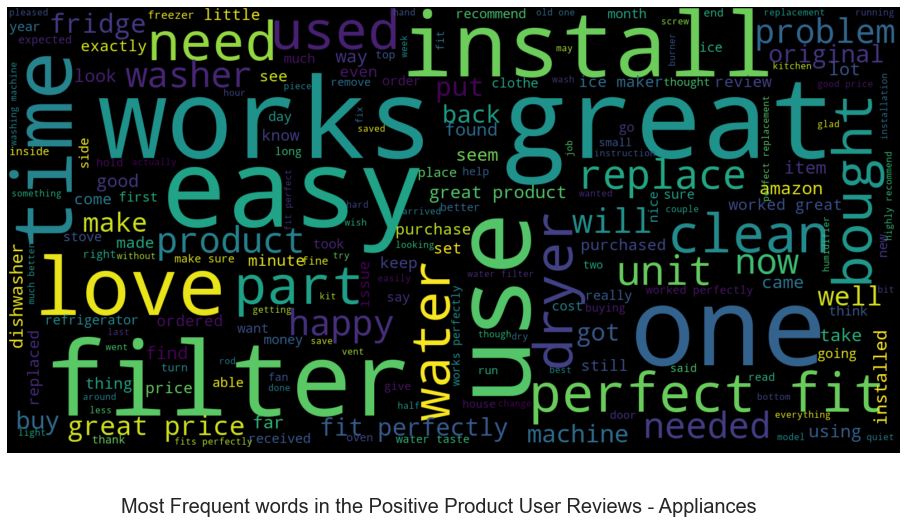

In [214]:
plot_wordcloud(appliances_df[appliances_df["V_Sentiment"] == "POSITIVE"]["reviewText"], "Most Frequent words in the Positive Product User Reviews - Appliances")

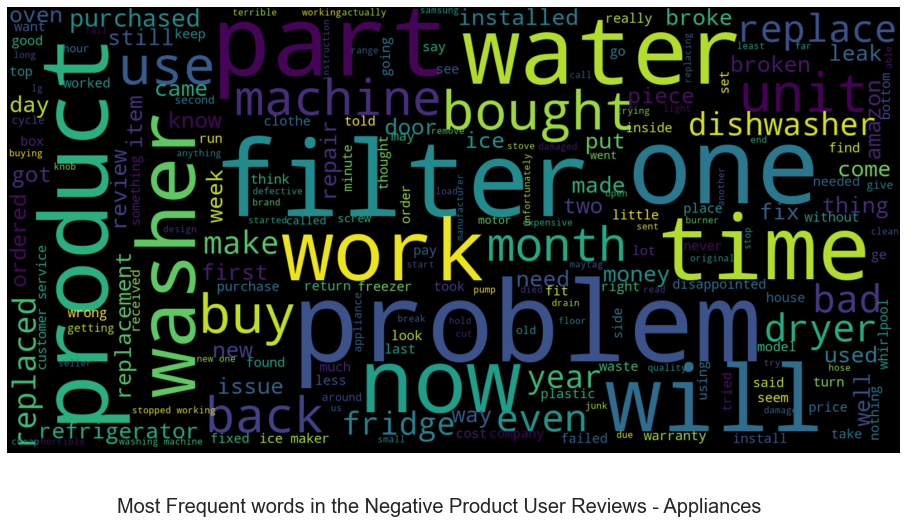

In [215]:
plot_wordcloud(appliances_df[appliances_df["V_Sentiment"] == "NEGATIVE"]["reviewText"], "Most Frequent words in the Negative Product User Reviews - Appliances")

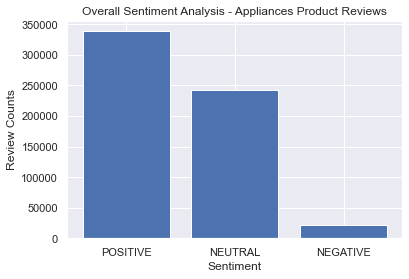

In [216]:
overall_sentiment = dict(appliances_df["V_Sentiment"].value_counts())
plt.title("Overall Sentiment Analysis - Appliances Product Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Review Counts")
plt.bar(overall_sentiment.keys(), overall_sentiment.values());

In [422]:
overall_sentiment_books = dict(reviews_df["V_Sentiment"].value_counts())
overall_sentiment_books.keys()

dict_keys(['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

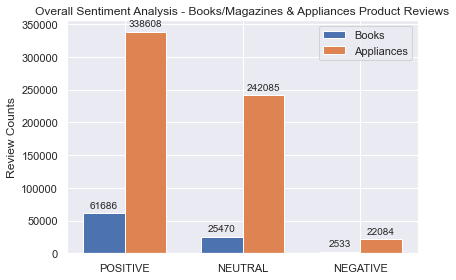

In [423]:
labels = list(overall_sentiment_books.keys())
book_sent_values = overall_sentiment_books.values()
app_sent_values = overall_sentiment.values()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, book_sent_values, width, label='Books')
rects2 = ax.bar(x + width/2, app_sent_values, width, label='Appliances')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Review Counts')
ax.set_title('Overall Sentiment Analysis - Books/Magazines & Appliances Product Reviews')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [424]:
appliances_df.overall.value_counts()

5    416288
4     75476
1     59627
3     30652
2     20734
Name: overall, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Topic Modeling Starts

In [238]:
app_corpora_tokens = []
appliances_df_80k = appliances_df.sample(80000)
for idx, review in appliances_df_1hk.iterrows():
    app_corpora_tokens.append([token for token in review["tokens"] if len(token) > 2 and token not in STOP_WORDS])

In [239]:
id2word = corpora.Dictionary(app_corpora_tokens)
print(id2word)

id2word.filter_extremes(no_below=3, no_above=0.3)
print(id2word)

app_corpus = [id2word.doc2bow(d) for d in app_corpora_tokens]

Dictionary(29165 unique tokens: ['4392065rc', 'bearing', 'broke', 'fate', 'fit']...)
Dictionary(11275 unique tokens: ['bearing', 'broke', 'fate', 'fit', 'perfect']...)


In [241]:
app_lda_model_4 = models.ldamodel.LdaModel(app_corpus, num_topics=4, id2word=id2word, passes=10)

In [242]:
app_lda_4cm = CoherenceModel(model=app_lda_model_4, corpus=app_corpus, coherence='u_mass')
app_lda_4cm_coherence = app_lda_4cm.get_coherence()
print(app_lda_4cm_coherence)

-2.419014221441622


In [243]:
app_vis_4 = pyLDAvis.gensim_models.prepare(app_lda_model_4, app_corpus, 
                                     dictionary=app_lda_model_4.id2word)
app_vis_4

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.158224 -0.163059       1        1  37.366742
0      0.119264 -0.007288       2        1  31.281699
2      0.076718  0.201908       3        1  17.721172
1     -0.354205 -0.031561       4        1  13.630386, topic_info=       Term          Freq         Total Category  logprob  loglift
28    great  22611.000000  22611.000000  Default  30.0000  30.0000
254  filter  19441.000000  19441.000000  Default  29.0000  29.0000
3       fit  17854.000000  17854.000000  Default  28.0000  28.0000
38     work  23310.000000  23310.000000  Default  27.0000  27.0000
109   water  16258.000000  16258.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
397    fine   2053.205759   4569.782301   Topic4  -4.7144   1.1928
19     part   3851.246914  13891.763689   Topic4  -4.0854   0.7100
705    item   2029.323603   4585.997069   Topic4  -4.7261   1.1776
213    like   2469.431109  10931.884854   Topic4  -4.5298   0.5052
345    time   1940.758855  11420.588647   Topic4  -4.7707   0.2205

[277 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4125      4  0.973252        1977
965       4  0.999480  advertised
221       1  0.582458        also
221       2  0.298914        also
221       3  0.118602        also
...     ...       ...         ...
114       4  0.065640       would
581       1  0.093091        year
581       2  0.704566        year
581       3  0.202245        year
752       2  0.999539     youtube

[407 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [244]:
app_lda_model_10 = models.ldamodel.LdaModel(app_corpus, num_topics=10, id2word=id2word, passes=10)

In [245]:
app_lda_10cm = CoherenceModel(model=app_lda_model_10, corpus=app_corpus, coherence='u_mass')
app_lda_10cm_coherence = app_lda_10cm.get_coherence()
print(app_lda_10cm_coherence)

-2.5783112411479037


In [246]:
app_vis_10 = pyLDAvis.gensim_models.prepare(app_lda_model_10, app_corpus, 
                                     dictionary=app_lda_model_10.id2word)
app_vis_10

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.006798 -0.049017       1        1  19.992521
3      0.063985  0.176410       2        1  12.862770
0     -0.048801 -0.050454       3        1  11.140960
1      0.160544 -0.136388       4        1  10.210915
4     -0.308554  0.187537       5        1   9.196115
9      0.139977 -0.074573       6        1   7.842138
7      0.113794 -0.106136       7        1   7.810096
5      0.088422  0.081247       8        1   7.144237
6     -0.323470 -0.196735       9        1   7.039191
8      0.107304  0.168111      10        1   6.761055, topic_info=        Term          Freq         Total Category  logprob  loglift
254   filter  19462.000000  19462.000000  Default  30.0000  30.0000
3        fit  17972.000000  17972.000000  Default  29.0000  29.0000
5    product  13875.000000  13875.000000  Default  28.0000  28.0000
28     great  22941.000000  22941.000000  Default  27.0000  27.0000
11      good  13908.000000  13908.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
900  kitchen    553.584087   2162.191893  Topic10  -5.3240   1.3315
844     nice    590.132641   3358.842837  Topic10  -5.2601   0.9550
879     star    541.360750   2143.863325  Topic10  -5.3463   1.3177
493   little    563.436190   4999.686790  Topic10  -5.3064   0.5109
543     side    527.100341   2877.272054  Topic10  -5.3730   0.9968

[634 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4047      5  0.992261      1000
1234     10  0.995109       3rd
753       6  0.856129  accurate
753      10  0.141509  accurate
3639      4  0.997494    adjust
...     ...       ...       ...
581       2  0.055170      year
581       3  0.073954      year
581       4  0.023775      year
581       7  0.020492      year
752       7  0.999588   youtube

[1212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5, 10, 8, 6, 7, 9])

In [247]:
app_lda_model_30 = models.ldamodel.LdaModel(app_corpus, num_topics=30, id2word=id2word, passes=10)

In [248]:
app_lda_30cm = CoherenceModel(model=app_lda_model_30, corpus=app_corpus, coherence='u_mass')
app_lda_30cm_coherence = app_lda_30cm.get_coherence()
print(app_lda_30cm_coherence)

-3.3071864322791757


In [249]:
app_vis_30 = pyLDAvis.gensim_models.prepare(app_lda_model_30, app_corpus, 
                                     dictionary=app_lda_model_30.id2word)
app_vis_30

C:\Project_Files\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.157822  0.052194       1        1  8.633715
22     0.124088  0.161562       2        1  5.952144
23     0.181900 -0.087266       3        1  5.412094
14     0.050011  0.235195       4        1  5.405833
15     0.181594 -0.061390       5        1  5.123615
28     0.173656  0.098982       6        1  4.961990
7      0.010227  0.047694       7        1  4.652679
24     0.127450 -0.021481       8        1  4.088984
1      0.140575 -0.051761       9        1  3.870074
11    -0.045471  0.202470      10        1  3.775470
21    -0.288136  0.092632      11        1  3.428227
29     0.075994  0.007327      12        1  3.162562
10     0.076602 -0.155272      13        1  2.965115
26    -0.268410 -0.162188      14        1  2.859257
4      0.108236 -0.069983      15        1  2.716187
0     -0.069391  0.043366      16        1  2.631805
20    -0.014049 -0.030987      17        1  2.600313
6     -0.200843 -0.136606      18        1  2.571398
19    -0.112096 -0.120817      19        1  2.540934
13    -0.209647  0.228970      20        1  2.504735
16     0.083290 -0.058294      21        1  2.372415
25    -0.010268  0.017389      22        1  2.370851
17     0.033850  0.118756      23        1  2.284808
9      0.029136 -0.142912      24        1  2.135082
5      0.046650 -0.086466      25        1  2.008896
2     -0.017613  0.005362      26        1  1.960237
8     -0.076436 -0.083960      27        1  1.927286
3     -0.126160 -0.008192      28        1  1.798794
27    -0.027708 -0.024160      29        1  1.798042
12    -0.134852 -0.010164      30        1  1.486458, topic_info=           Term          Freq         Total Category  logprob  loglift
254      filter  20050.000000  20050.000000  Default  30.0000  30.0000
3           fit  18276.000000  18276.000000  Default  29.0000  29.0000
28        great  22648.000000  22648.000000  Default  28.0000  28.0000
38         work  23166.000000  23166.000000  Default  27.0000  27.0000
115        easy  11802.000000  11802.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
705        item    548.466758   4854.566079  Topic30  -3.8185   2.0282
496     looking    341.048800   1876.783809  Topic30  -4.2936   2.5035
149        came    370.909082   4657.658515  Topic30  -4.2097   1.6785
457  everything    208.955430   1988.315137  Topic30  -4.7835   1.9559
295     ordered    213.153491   3117.013566  Topic30  -4.7636   1.5262

[1654 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
983       4  0.004423      100
983      12  0.219674      100
983      22  0.775492      100
964      22  0.992778      150
1111     12  0.198989      200
...     ...       ...      ...
4042     28  0.954664    young
752       4  0.947778  youtube
752       8  0.050876  youtube
1940     21  0.996222    youve
639       1  0.996202     zero

[3036 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 23, 24, 15, 16, 29, 8, 25, 2, 12, 22, 30, 11, 27, 5, 1, 21, 7, 20, 14, 17, 26, 18, 10, 6, 3, 9, 4, 28, 13])

In [370]:
pyLDAvis.save_html(app_vis_30, 'lda_50_topics_appliances_reviews.html')

#  Understanding the text in the Product Titles

In [272]:
books_df

id                                              title group  \
11          12  Fantastic Food with Splenda : 160 Great Recipe...  Book   
32          33                                    Double Jeopardy  Book   
38          39                     Night of Many Dreams : A Novel  Book   
44          45                                      Beginning ASP  Book   
73          74                                   Service Delivery  Book   
...        ...                                                ...   ...   
542672  548541                           Para alcanzar el orgasmo  Book   
542673  548542           Starting a Hedge Fund : A US Perspective  Book   
542674  548543             Facts Every Injured Worker Should Know  Book   
542677  548546                  Adobe Photoshop 6 VTC Training CD  Book   
542680  548549      Catholic Bioethics and the Gift of Human Life  Book   

        salesrank  review_cnt  downloads  rating  \
11          24741          12         12     4.5   
32          97166           4          4     5.0   
38          57186          22         22     3.5   
44          48408           4          4     4.0   
73          27507           2          2     4.0   
...           ...         ...        ...     ...   
542672          0           1          1     4.0   
542673          0           3          3     2.5   
542674          0           5          5     4.5   
542677          0           2          2     5.0   
542680          0           1          1     4.0   

                                                   tokens  
11      [fantastic, food, splenda, 160, great, recipes...  
32                                     [double, jeopardy]  
38                           [night, many, dreams, novel]  
44                                       [beginning, asp]  
73                                    [service, delivery]  
...                                                   ...  
542672                      [para, alcanzar, el, orgasmo]  
542673           [starting, hedge, fund, us, perspective]  
542674              [facts, every, injured, worker, know]  
542677           [adobe, photoshop, 6, vtc, training, cd]  
542680           [catholic, bioethics, gift, human, life]  

[74553 rows x 8 columns]

<AxesSubplot:title={'center':'POS tagging for Book Titles'}>

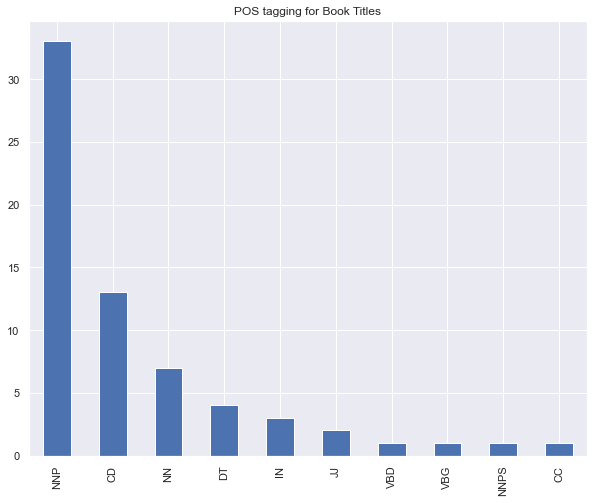

In [276]:
from textblob import TextBlob
title_blob = TextBlob(str(books_df['title']))
title_pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'parts_of_speech'])
title_pos_df = title_pos_df.parts_of_speech.value_counts()[:20]
title_pos_df.plot(kind = 'bar', figsize=(10, 8), title = "POS tagging for Book Titles")

As expected majority of the words in the Titles are Nouns.

<AxesSubplot:title={'center':'Bigram Distb for most significant 20 words in the Titles'}, xlabel='bigram'>

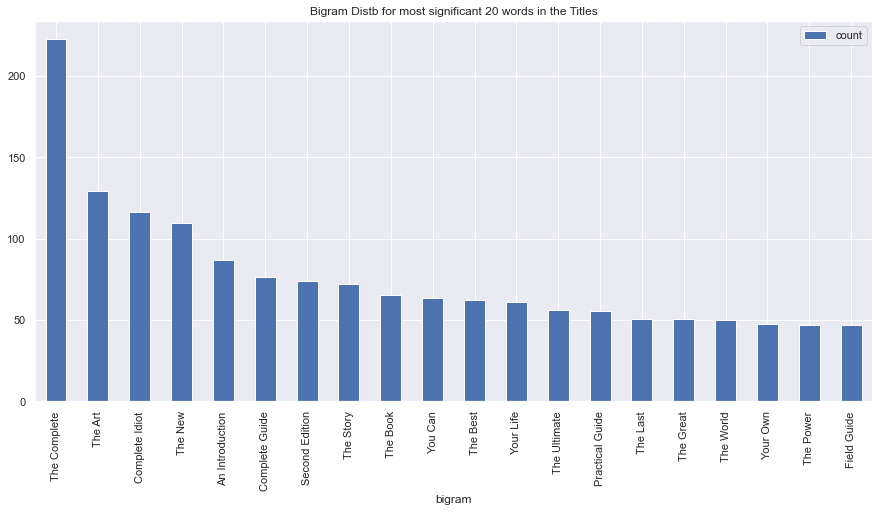

In [278]:
tf_title = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
title_tfidf_matrix = tf_title.fit_transform(books_df['title'])
all_words = title_tfidf_matrix.sum(axis=0) 

occurance = [(word, all_words[0, idx]) for word, idx in tf_title.vocabulary_.items()]
occurance = sorted(occurance, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram Distb for most significant 20 words in the Titles", figsize = (15,7), )

# Product Recommendations


To determine the top similar products, Ego Network analysis is applied. In an Ego Network, neighbors with close social relations are adjacent and form a portion of social network. Retrieving them under certain radius would give the top recommendations.

In [250]:
from operator import itemgetter
import networkx
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

In [252]:
books_path = os.path.join(os.getcwd(), r"..\datasets\amazon-meta.txt\amazon-books.csv")

In [254]:

products_data = pd.read_csv(books_path, index_col=0)
products_data.head()

Id                                              Title  \
0827229534   1            Patterns of Preaching: A Sermon Sampler   
0738700797   2                         Candlemas: Feast of Flames   
0486287785   3   World War II Allied Fighter Planes Trading Cards   
0842328327   4  Life Application Bible Commentary: 1 and 2 Tim...   
1577943082   5    Prayers That Avail Much for Business: Executive   

                                                   Categories  SalesRank  \
0827229534  clergy books preaching subjects sermons religi...     396585   
0738700797  books wicca subjects based religion religions ...     168596   
0486287785  books subjects hobbies general home crafts garden    1270652   
0842328327  guides living subjects sacred discipleship bib...     631289   
1577943082  prayerbooks books living subjects christian re...     455160   

            TotalReviews  AvgRating  DegreeCentrality  ClusteringCoeff  
0827229534             2        5.0                 8         0.464286  
0738700797            12        4.5                 9         0.583333  
0486287785             1        5.0                 0         0.000000  
0842328327             1        4.0                 6         0.600000  
1577943082             0        0.0                 4         1.000000

In [255]:
products_data.shape

(393561, 8)

In [256]:
products_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393561 entries, 0827229534 to 0879736836
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                393561 non-null  int64  
 1   Title             393561 non-null  object 
 2   Categories        375139 non-null  object 
 3   SalesRank         393561 non-null  int64  
 4   TotalReviews      393561 non-null  int64  
 5   AvgRating         393561 non-null  float64
 6   DegreeCentrality  393561 non-null  int64  
 7   ClusteringCoeff   393561 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 27.0+ MB


In [259]:
books_graph_path = os.path.join(os.getcwd(), r"..\datasets\amazon-meta.txt\amazon-books-copurchase.edgelist")

In [260]:
with open(books_graph_path, 'rb') as f:
    azb_copurchase_G = networkx.read_weighted_edgelist(f)

In [261]:
def apply_scaling(df):
    num_cols     = ['TotalReviews', 'AvgRating', 'DegreeCentrality']
    num_abs_cols = ['SalesRank']

    min_max_sclr = MinMaxScaler()
    max_abs_sclr = MaxAbsScaler()

    # Apply Min-Max Scaler
    df_min_max   = pd.DataFrame(min_max_sclr.fit_transform(df[num_cols]), 
                           columns=['mms_' + col for col in num_cols], 
                           index=df.index)
    df_min_max   = pd.concat([df, df_min_max], axis=1)
    df_min_max   = df_min_max.drop(num_cols, axis=1)

    # Apply Absolute Scaler
    df_abs       = pd.DataFrame(max_abs_sclr.fit_transform(df_min_max[num_abs_cols]), 
                            columns=['mas_' + col for col in num_abs_cols], 
                            index=df.index)
    df_abs = pd.concat([df_min_max, df_abs], axis=1)
    df_abs = df_abs.drop(num_abs_cols, axis=1)

    return df_abs

In [264]:
# Perform Min-Max and Absolute scaling
data = apply_scaling(products_data).copy()

In [265]:
new_column_names = {'mms_TotalReviews': 'TotalReviews', 
                    'mms_AvgRating': 'AvgRating', 
                    'mms_DegreeCentrality': 'DegreeCentrality', 
                    'mas_SalesRank': 'SalesRank'
                   }

data = data.rename(columns=new_column_names)

In [266]:
def get_recos_metadata(df, recos, order="top"):
    df = df[df.index.isin(recos)].copy()
    df['TotalScore']  = df['AvgRating'] * df['TotalReviews'] * df['ClusteringCoeff'] * df['DegreeCentrality']

    # Scale the data
    max_abs_sclr = MaxAbsScaler()
    num_abs_cols = ['TotalScore']
    df_abs = pd.DataFrame(max_abs_sclr.fit_transform(df[num_abs_cols]), 
                          columns=['mas_' + col for col in num_abs_cols], 
                          index=df.index)
    df_abs = pd.concat([df, df_abs], axis=1).drop(num_abs_cols, axis=1)

    df.sort_values(by=['TotalScore', 'SalesRank'], ascending=[False, True], inplace=True)

    # Return Top-5 only if there are "atleast" five records
    if df.__len__() > 5:
        if order == 'top':
            return df[:5]
        elif order == 'bottom':
            return df[-5:]
    else:
        return df

In [361]:
def get_recommedations(data, query_asin, rad=1, order="top"):
    # Print some metadata
    print("--------------")
    print("Query Metadata: ")
    print("--------------")
    print("ASIN        : {}".format(query_asin))
    print("TITLE       : {}".format(data.loc[query_asin, 'Title']))
    print("AVG. RATING : {}".format(data.loc[query_asin, 'AvgRating']))

    try:
        # Create an ego-graph
        azb_copurchase_egoG = networkx.ego_graph(azb_copurchase_G, query_asin, radius=rad)
    except Exception as e:
        print(f"Error: {e}")
        print("There are no similar items. Please choose another ASIN.")
        return

    # Create a subgraph with only edges having weight >= 0.5
    weighted_G = networkx.Graph()
    azb_copurchase_egoG_trimmed = [weighted_G.add_edge(edges[0], edges[1], weight=edges[2]['weight']) \
                                   for edges in azb_copurchase_egoG.edges(data=True) if edges[2]['weight'] >= 0.25]
    weighted_G_trimmed = weighted_G
    print("--------------")
    print("Amazon Metadata Similar Products: ")
    print("--------------")
    cou = 0
    for edge in azb_copurchase_G[query_asin]:
        if cou > 4:
            break
        amzn_simi = prod_df[prod_df.asin == str(edge)]
        print("TITLE       : {}".format(amzn_simi.iat[0,2]))
        cou += 1
    

    # Get the recommedations
    recommendations = [nbg for nbg in weighted_G_trimmed.neighbors(query_asin)]
    recommendations = get_recos_metadata(data.copy(), recommendations, order)
    print("---------------------")
    print("Top Recommendations")
    print("---------------------")
    print(json.dumps(recommendations[['Id', 'Title', 'AvgRating']].to_dict(), indent=2))
    print("*****")

In [362]:
get_recommedations(data, query_asin = '0805047905', rad=1, order="top")

--------------
Query Metadata: 
--------------
ASIN        : 0805047905
TITLE       : Brown Bear, Brown Bear, What Do You See?
AVG. RATING : 1.0
--------------
Amazon Metadata Similar Products: 
--------------
TITLE       : Goodnight Moon
TITLE       : Where Is Baby
TITLE       : Jamberry Board Book
TITLE       : The Runaway Bunny
TITLE       : Guess How Much I Love You
---------------------
Top Recommendations
---------------------
{
  "Id": {
    "0060207051": 276038,
    "0060094273": 110200,
    "0694016756": 539175,
    "0694700940": 300850,
    "0694010081": 537970
  },
  "Title": {
    "0060207051": "Goodnight Moon",
    "0060094273": "Goodnight Moon Board Book & Baby Socks",
    "0694016756": "Goodnight Moon",
    "0694700940": "Goodnight Moon (Board Book and Audio Cassette)",
    "0694010081": "Goodnight Moon Board Book and Slippers"
  },
  "AvgRating": {
    "0060207051": 0.9,
    "0060094273": 0.9,
    "0694016756": 0.9,
    "0694700940": 0.9,
    "0694010081": 0.9
  }
}
***

In [363]:
get_recommedations(data, query_asin = '0486287785', rad=1, order="top")

--------------
Query Metadata: 
--------------
ASIN        : 0486287785
TITLE       : World War II Allied Fighter Planes Trading Cards
AVG. RATING : 1.0
Error: Source 0486287785 is not in G
There are no similar items. Please choose another ASIN.


In [364]:
get_recommedations(data, query_asin = '1577943082', rad=3, order="bottom")

--------------
Query Metadata: 
--------------
ASIN        : 1577943082
TITLE       : Prayers That Avail Much for Business: Executive
AVG. RATING : 0.0
--------------
Amazon Metadata Similar Products: 
--------------
TITLE       : Prayers That Avail Much for the Workplace: The Business Handbook of Scriptural Prayer
TITLE       : Prayers That Avail Much: Three Bestselling Works Complete In One Volume  25th Anniversary Commemorative
TITLE       : Prayers That Avail Much for Men
TITLE       : Prayers That Avail Much for Kids: Short and Simple Prayers Packed With the Power of God
---------------------
Top Recommendations
---------------------
{
  "Id": {
    "0892749504": 173362,
    "1577941829": 489756,
    "157794349X": 305321
  },
  "Title": {
    "0892749504": "Prayers That Avail Much: Three Bestselling Works Complete In One Volume, 25th Anniversary Commemorative",
    "1577941829": "Prayers That Avail Much for Men",
    "157794349X": "Prayers That Avail Much for the Workplace: The Bu

In [365]:
get_recommedations(data, query_asin = '0486220125', rad=1, order="bottom")

--------------
Query Metadata: 
--------------
ASIN        : 0486220125
TITLE       : How the Other Half Lives: Studies Among the Tenements of New York
AVG. RATING : 0.8
--------------
Amazon Metadata Similar Products: 
--------------
TITLE       : The Battle with the  Slum
TITLE       : Five Points: The 19th Century New York City Neighborhood That Invented Tap Dance  Stole Elections  and Became the World
TITLE       : Old New York in Early Photographs
TITLE       : Jacob Riis
---------------------
Top Recommendations
---------------------
{
  "Id": {
    "0452283612": 495077,
    "0486401960": 162248,
    "0486229076": 298989,
    "0714840343": 398542
  },
  "Title": {
    "0452283612": "Five Points: The 19th Century New York City Neighborhood That Invented Tap Dance, Stole Elections, and Became the World's Most Notorious Slum",
    "0486401960": "The Battle with the Slum",
    "0486229076": "Old New York in Early Photographs",
    "0714840343": "Jacob Riis (55)"
  },
  "AvgRating": {

In [366]:
get_recommedations(data, query_asin = '0787950599', rad=1, order="bottom")

--------------
Query Metadata: 
--------------
ASIN        : 0787950599
TITLE       : Resolving Conflicts At Work : A Complete Guide for Everyone on the Job
AVG. RATING : 0.9
--------------
Amazon Metadata Similar Products: 
--------------
TITLE       : The Eight Essential Steps to Conflict Resolution
TITLE       : Conflict Resolution
TITLE       : Difficult Conversations: How to Discuss what Matters Most
TITLE       : Coward
TITLE       : The Dynamics of Conflict Resolution: A Practitioner
---------------------
Top Recommendations
---------------------
{
  "Id": {
    "014028852X": 84467,
    "1402200552": 284568,
    "0874777518": 511273,
    "078795019X": 458709,
    "0071364315": 517189
  },
  "Title": {
    "014028852X": "Difficult Conversations: How to Discuss what Matters Most",
    "1402200552": "Coward's Guide to Conflict: Empowering Solutions for Those Who Would Rather Run Than Fight",
    "0874777518": "The Eight Essential Steps to Conflict Resolution",
    "078795019X": "Th

Clearly the ego network based recommendations match the top similar products mentioned in the meta-data.txt by Amazon. Thus our analysis is correct.

# Future

Use BERT kind of Deeplearning models for analyzing based on product text and recommending products outside the categories.

# References
https://radimrehurek.com/gensim/models/coherencemodel.html